# **Part 1: Summary Statistics of NYC Housing Court Records**

In [ ]:
## Import Libraries ##

from google.colab import drive
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
## Load Data ##

!pip install nycdb
!nycdb --download oca
!nycdb --load oca
addresses = pd.read_csv('/content/data/oca_addresses.csv')
decisions = pd.read_csv("/content/data/oca_decisions.csv")
index = pd.read_csv("/content/data/oca_index.csv")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 10.5 MB/s eta 0:00:00
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0
INFO:root:Downloading https://s3.amazonaws.com/oca-data/public/oca_index.csv to /content/data/oca_index.csv
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "GET /oca-data/public/oca_index.csv HTTP/1.1" 200 339493525
100% 324M/324M [00:04<00:00, 81.6MB/s]
INFO:root:Downloading https://s3.amazonaws.com/oca-data/public/oca_causes.csv to /content/data/oca_causes.csv
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.c

###Residential court cases by borough

Bouroughs by zip code
* Manhattan: 10001-10282
* Staten Island : 10301-10314
* Bronx: 10451-10475
* Queens: 11004-11109, 11351-11697
* Brooklyn: 11201-11256

In [ ]:
#Create a borough categorizer by zip codes

def categorize_borough(row):  
  if row['zip'] >= 10001 and row['zip'] <= 10282:
    return 'manhattan'
  elif row['zip'] >= 10301 and row['zip'] <= 10314:
    return 'staten island'
  elif row['zip'] >= 10451  and row['zip'] <= 10475:
    return 'bronx'
  elif (row['zip'] >= 11004  and row['zip'] <= 11109) or (row['zip'] >= 11351  and row['zip'] <= 11697):
    return 'queens'
  elif row['zip'] >= 11201  and row['zip'] <= 11256:
    return 'brooklyn'
  return 'Outside NYC'

In [ ]:
# Remove last 4 digits of postal code
ziplist = []
for zip in addresses["postalcode"]:
    zip_shortened = re.sub('-\d{4}$', '', zip)
    ziplist.append(zip_shortened) #append to list
addresses["zip"]=ziplist #add list as column

addresses['zip'] = addresses['zip'].astype(int) #Convert string to numeric
 
#Apply borough expression to create a borough variable
addresses['borough'] = addresses.apply(lambda row: categorize_borough(row), axis=1)

In [ ]:
#1. Check what property types there are
index.propertytype.value_counts()
#2. Merge index w/addresses to get borough and property types
df = pd.merge(index, addresses)
#3. Subset down to resident housing
residential_df = df[df["propertytype"] == 'Residential']
#4. Subset down to cities in Brooklyn, Bronx, Manhattan, Staten Island, Queens, and manhattan
residential_df = residential_df.loc[residential_df['borough'].isin(['brooklyn', "bronx", "manhattan", "staten island", "queens"])]
#5. Group the residential housing by bourough
residential_df.borough.value_counts()

bronx            539261
brooklyn         454223
manhattan        334827
queens           268608
staten island     37256
Name: borough, dtype: int64

###Court cases by month

Residential only

In [ ]:
# Create new column that extracts month from the filedate
monthlist = []
for i in residential_df["fileddate"]:
  month_str = re.search('-(.+?)-', i).group(1) #extract month w/regexp
  monthlist.append(month_str) #append to list
residential_df["month"]=monthlist #add list as column

# Count housing for each month
residential_df.month.value_counts()

08    150721
03    147143
10    143989
01    137725
09    137459
02    137010
06    134992
05    134552
11    131669
07    129942
04    126661
12    122312
Name: month, dtype: int64

Residential and Commercial

In [ ]:
# Create new column that extracts month from the filedate
monthlist = []
for i in df["fileddate"]:
  month_str = re.search('-(.+?)-', i).group(1) #extract month w/regexp
  monthlist.append(month_str) #append to list
df["month"]=monthlist #add list as column

# Count housing for each month
df.month.value_counts()

08    221292
10    207843
03    201335
09    200599
06    200444
07    194895
01    193538
05    190754
02    188453
11    187747
04    177924
12    170779
Name: month, dtype: int64

###Top 10 NYC ZIP codes with residential court cases before pandemic

In [ ]:
# 1. Convert date to datetime type
residential_df['fileddate']= pd.to_datetime(residential_df['fileddate'])

# 2. Get pre-covid cases by zip code #
residential_precovid = residential_df.loc[(residential_df['fileddate'] < '2020-03-01')] # Subset to pre-covid

# 3. Get ZIP codes w/residential court cases pre-covid
precovid_cases = residential_precovid.zip.value_counts()
print(residential_precovid.zip.value_counts().head(10)) # Display top 10 zip codes w/most court cases

10456    31881
10453    29872
10457    25781
10467    25722
10452    25323
11212    24128
10458    22940
10468    22622
11226    21662
10029    19300
Name: zip, dtype: int64


###Top 10 NYC ZIP codes with residential court cases post-pandemic

In [ ]:
# Get post-covid cases #
residential_postcovid = residential_df.loc[(residential_df['fileddate'] >= '2020-03-01')] # Subset to post-covid
# Count number of cases per zip code post-covid
postcovid_cases = residential_postcovid.zip.value_counts()
print(postcovid_cases.head(20))

10453    16535
11226    16518
10467    15040
10456    14865
10457    14260
10458    14193
10452    14094
10468    13539
11212    11256
11207    10630
10031     9764
10460     9752
11368     9663
11233     9418
11225     9259
11213     9104
10462     9007
11208     8936
10032     8674
11203     8672
Name: zip, dtype: int64


###Comparing the change in court cases since the pre-pandemic

In [ ]:
# Convert postcovid and precovid case number into dataframes and merge
precovid_cases = residential_precovid.zip.value_counts().rename_axis('zip').to_frame('precovid_cases')

# Create column subtracting postcovid and precovid case number
postcovid_cases = residential_postcovid.zip.value_counts().rename_axis('zip').to_frame('postcovid_cases')

# Merge pre-covid and post-covid case count by zip code
cases = pd.merge(precovid_cases, postcovid_cases, on = "zip")

# Create column getting change in cases
cases['case_difference'] = cases['postcovid_cases'] - cases["precovid_cases"]

cases.sort_values(by = "case_difference", ascending = False).head(10) # sort in ascending order

,precovid_cases,postcovid_cases,case_difference
zip,,,
11550,15,4137,4122
11520,24,1133,1109
11590,3,905,902
11105,1677,2035,358
11575,9,336,327
11581,1,297,296
10005,464,747,283
11021,6,273,267
11417,898,1129,231


In [ ]:
#*For GIS Analysis: Merge evictions data w/renters while there is still longitude and latitude in the dataset

#Group by zip code and count evictions
residential_df.head()
residential_df['court_cases'] = residential_df.groupby(['zip'])['indexnumberid'].transform('count') 
residential_df2 = residential_df.drop_duplicates(subset=['zip'], keep='first')
residential_df2.to_csv("court_cases.csv") #export to csv file

# **Part 2: Predicting eviction cases**

#Model 1: Predicting eviction from denial in court

Target variable data

In [ ]:
# Extract decision from highlight
decisionslist = []
for decision in decisions["highlight"]:
    decision = decision[0:4] #get first 4 digits
    decisionslist.append(decision) #append to list
decisions["decision"] = decisionslist #add list as column
decisions.decision.value_counts() #Produce value counts

# Judg and Defa = Judgment/Default Judgment Verdict
# Denied = Decision Denied, Null, Stipulated Verdict

Judg    749625
Deci      5280
Defa      3692
null       166
Stip       154
Name: decision, dtype: int64

In [ ]:
#Create a borough variable by zip codes
def categorize_verdict(row):  
  if row['decision'] == "Judg":
    return 1 #Judgment
  elif row['decision'] == "Defa":
    return 1
  elif row['decision'] == "Deci":
    return 0 #denied, null, stip
  elif row['decision'] == "Stip":
    return 0
  elif row['decision'] == "null":
    return 0 
#Apply borough expression to create a borough variable
decisions['verdict'] = decisions.apply(lambda row: categorize_verdict(row), axis=1)

In [ ]:
#Merge index with verdict
decisions_address = pd.merge(decisions, addresses, on = "indexnumberid", how = "left")

In [ ]:
def clean_rent_data(file, level):
  df = pd.read_csv(file)
  
  # Move first row as header
  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header
  df.head()

  # Remove any columns starting with annotation or margin
  unwanted = df.columns[df.columns.str.startswith('Margin', na = False)] #select columns starting w/count
  df.drop(unwanted, axis=1, inplace=True) # drop columns
  unwanted2 = df.columns[df.columns.str.startswith('Annotation', na = False)] #select columns starting w/count
  df.drop(unwanted2, axis=1, inplace=True) # drop columns

  # Keep only data on renters and location
  df = df.filter(regex='Renter|Geo')

  #Remove unwanted substring from column header
  remove = "Estimate!!Renter-occupied housing units!!Occupied housing units!!"
  df.columns = df.columns.str.replace(remove,'')

  #Remove unwanted substring from column header
  remove2 = "RACE AND HISPANIC OR LATINO ORIGIN OF HOUSEHOLDER!!"
  remove3 = "One race --!!"
  remove4 = "AGE OF HOUSEHOLDER!!"
  remove5 = "EDUCATIONAL ATTAINMENT OF HOUSEHOLDER!!"
  remove6 = "YEAR HOUSEHOLDER MOVED INTO UNIT!!"
  remove_list = [remove2, remove3, remove4, remove5, remove6]
  i = 0
  for i in range(len(remove_list)):
    df.columns = df.columns.str.replace(remove_list[i],'')
  
  #Features for Model 1 
  if level == "zip":
    # clean zip variable
    df.rename(columns = {'Geographic Area Name':'zip'}, inplace = True) #Rename column to zip
    df['zip'] = df['zip'].str.replace("ZCTA5 ","").astype(int) #Remove unwanted name and convert to int
    #Merge renter demographic data with evicion data
    df = pd.merge(decisions_address[['verdict', 'zip']], df, on = "zip")

    # Remove any unnecessary columns
    df.head()
    remove_these_cols = ["Geography"] 
    df = df.drop(columns = remove_these_cols)

    # Remove any rows if they have more than 6 missing values or 6 zeros
    df = df[df.isnull().sum(axis=1) < 6]
    df = df[df.where(df == 0).sum(axis=1) < 6]
    # Return DF
    return(df)

  #Features for Model 2
  elif level == "tract":

    #Subset renters tract data to 5 counties
    df = df[df["Geographic Area Name"].str.contains('Bronx|Kings|New York|Queens|Richmond|Nassau')]

    # Extract 6 digit census tract data from column #
    df["Census Tract"] = df['Geography'].str[-6:]

    #Remove zeros in census tract (to match eviction data with census tract later)
    df["Census Tract"] = df['Census Tract'].str.strip('0')
    df["Census Tract"].head(10)
    df['Census Tract'] = df['Census Tract'].astype(float)

    # Add borough based on geographic area info 
    def categorize_borough2(row):  
      if "Bronx" in row['Geographic Area Name']:
        return 'bronx'
      elif "King" in row['Geographic Area Name']:
        return 'brooklyn'
      elif "New York County" in row['Geographic Area Name']:
        return 'manhattan'
      elif "Richmond" in row['Geographic Area Name']:
        return 'staten island'
      elif ("Nassau" in row['Geographic Area Name']) or ("Queens" in row['Geographic Area Name']):
        return 'queens'
      return 'Outside NYC'

    #Apply borough expression to create a borough variable
    df['borough'] = df.apply(lambda row: categorize_borough2(row), axis=1)

    ## Import selected housing characteristic data (uncleaned)to add additional housing variables ##
    housing_data = pd.read_csv('/content/gdrive/My Drive/renter_data_uncleaned.csv')
    #Move first row as header
    new_header = housing_data.iloc[0] #grab the first row for the header
    housing_data = housing_data[1:] #take the data less the header row
    housing_data.columns = new_header #set the header row as the df header

    #Remove any columns starting with annotation or margin
    unwanted = housing_data.columns[housing_data.columns.str.startswith('Margin', na = False)] #select columns starting w/count
    housing_data.drop(unwanted, axis=1, inplace=True) # drop columns
    unwanted2 = housing_data.columns[housing_data.columns.str.startswith('Annotation', na = False)] #select columns starting w/count
    housing_data.drop(unwanted2, axis=1, inplace=True) # drop columns
    unwanted2 = housing_data.columns[housing_data.columns.str.startswith('Percent', na = False)] #select columns starting w/count
    housing_data.drop(unwanted2, axis=1, inplace=True) # drop columns
    
    #Remove unwanted substring from column header
    remove = "Estimate!!"
    housing_data.columns = housing_data.columns.str.replace(remove,'')

    #Select columns of interest
    housing_data = housing_data.filter(regex='Geography|Median|Occupied housing units!!Lacking|No telephone service available')

    #Remove unwanted substring from column header
    remove2 = "SELECTED CHARACTERISTICS!!Occupied housing units!!"
    remove3 = "GROSS RENT!!Occupied units paying rent!!"
    remove_list = [remove2, remove3]
    for i in range(len(remove_list)):
      housing_data.columns = housing_data.columns.str.replace(remove_list[i],'')
    
    #merge housing characteristics with cleaned renters df
    df = pd.merge(housing_data, df, on = "Geography")

    #return data
    return(df)

In [ ]:
#Clean data at the zip and census level
data_zip = clean_rent_data('/content/gdrive/My Drive/renters_zip_data.csv', level = "zip")
data_ct = clean_rent_data('/content/gdrive/My Drive/renters_ct_data.csv', level = "tract")

<ipython-input-18-b36797cd8005>:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,

In [ ]:
y = data_zip["verdict"]
x = data_zip.loc[:, data_zip.columns != 'verdict']
#Split data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 1) #Split data. X is explanatory, and y is a target variable

In [ ]:
#Build logistic regression model
log = LogisticRegression()
log.fit(x_train, y_train)
prediction = log.predict(x_test) 
print("Predictions: ", prediction)
print("Logistic Regression .coef_: {}".format(log.coef_))
print("Logistic Regression test score : {:.3f}".format(log.score(x_test, y_test)))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Predictions:  [1 1 1 ... 1 1 1]
Logistic Regression .coef_: [[ 3.60260368e-04 -3.62001670e-05 -1.54806788e-04  1.17696319e-04
   5.50319732e-05  5.50441769e-05  3.44239131e-06 -8.85252746e-05
  -2.40829647e-05  3.02466816e-04  2.41025071e-04 -1.45378197e-04
  -1.00957029e-04 -2.56449771e-04  2.11716424e-04  1.75573025e-04
  -3.43387995e-05  1.13634182e-04 -1.02354046e-05 -1.00410614e-04
   7.40214001e-05  4.24451706e-07  2.47745360e-04 -1.38762229e-05
  -2.60603313e-06 -2.55977862e-04 -9.21134857e-05  8.06280769e-05]]
Logistic Regression test score : 0.986


In [ ]:
# Create readable format for coefficients
col_names = list(x.columns.values.tolist()) #Get Column Names from explanatory variables
coefs = pd.DataFrame(log.coef_) #Convert logistic regression coefficients into a dataframe
coefs.columns = col_names
pd.set_option('display.max_columns', None)
coefs

,zip,Estimate!!Renter-occupied housing units!!Occupied housing units,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Two or more races,Hispanic or Latino origin,"White alone, not Hispanic or Latino",Under 35 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Less than high school graduate,High school graduate (includes equivalency),Some college or associate's degree,Bachelor's degree or higher,Moved in 2019 or later,Moved in 2015 to 2018,Moved in 2010 to 2014,Moved in 2000 to 2009,Moved in 1990 to 1999,Moved in 1989 or earlier
0,0.00036,-0.000036,-0.000155,0.000118,0.000055,0.000055,0.000003,-0.000089,-0.000024,0.000302,0.000241,-0.000145,-0.000101,-0.000256,0.000212,0.000176,-0.000034,0.000114,-0.00001,-0.0001,0.000074,4.244517e-07,0.000248,-0.000014,-0.000003,-0.000256,-0.000092,0.000081


#Model 2: Eviction at the census tract level

In [ ]:
# Load evictions data
evictions = pd.read_csv('/content/gdrive/My Drive/evictions.csv')

In [ ]:
# Group by and count evictions per census
evictions['evictions'] = evictions.groupby(['Census Tract'])['Census Tract'].transform('count')
evictions = evictions.drop_duplicates(['Census Tract'])

# Lowercase borough
evictions['borough']=evictions['BOROUGH'].map(str.lower)
evictions['borough'] = evictions['borough'].apply(str.lower)

In [ ]:
# Merge evictions with renters data
data_ct2 = pd.merge(evictions[['Census Tract', 'evictions', 'borough']], data_ct, on = ['Census Tract', "borough"], how = "left")
data_ct2 = data_ct2[data_ct2['Median (dollars)'].notna()]

# Remove any unnecessary columns
remove_these_cols = ["Geography", "Geographic Area Name", "White"]
data_ct2 = data_ct2.drop(columns = remove_these_cols)
data_ct2 = data_ct2[data_ct2.columns.drop(list(data_ct2.filter(regex='OWNER|Owner')))]

In [ ]:
#* export data for robust clustered-se analysis
data_ct2.to_csv("renters_data_ct.csv")
#* export data for spatial analysis
data_zip4 = data_zip.drop_duplicates(subset=['zip'], keep="first")
data_zip4.to_csv("renters_data_zip.csv")

In [ ]:
# Label encode borough
data_ct2['borough'] = LabelEncoder().fit_transform(data_ct2['borough'])

# Convert object data to numeric
df_cat = data_ct2.select_dtypes(include=['O']) 
df_cat = df_cat.apply(pd.to_numeric, errors = 'coerce')

# Combine numeric with the newly numeric variables
df_num = data_ct2.select_dtypes(include=[np.number]) #Subset data to columns of numeric type
data_ct2 = pd.concat([df_num, df_cat], axis=1)

# Remove any rows w/ missing values in rent variable
data_ct2 = data_ct2[data_ct2['Median (dollars)'].notna()]

In [ ]:
# Train test split
y = data_ct2["evictions"]
X = data_ct2.loc[:, data_ct2.columns != 'evictions']

Xs = sm.add_constant(X) #add constant to the line

# Linear Regression
model = sm.GLM(y, Xs).fit()
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              evictions   No. Observations:                 1110
Model:                            GLM   Df Residuals:                     1079
Model Family:                Gaussian   Df Model:                           30
Link Function:               identity   Scale:                          1159.4
Method:                          IRLS   Log-Likelihood:                -5475.2
Date:                Thu, 19 Jan 2023   Deviance:                   1.2510e+06
Time:                        19:15:01   Pearson chi2:                 1.25e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
const                                                              11.5187      9.134      1.261      0.207      -6.384      29.421
Census Tract                                                       -0.0002   3.72e-05     -5.414      0.000      -0.000      -0.000
borough                                                            -4.0159      1.081     -3.714      0.000      -6.135      -1.897
ROOMS!!Total housing units!!Median rooms                           -0.2712      1.626     -0.167      0.868      -3.458       2.916
Lacking complete plumbing facilities                               -0.1330      0.063     -2.118      0.034      -0.256      -0.010
Lacking complete kitchen facilities                                 0.1836      0.046      3.976      0.000       0.093       0.274
No telephone service available                                     -0.1333      0.037     -3.632      0.000      -0.205      -0.061
Median (dollars)                                                    0.0062      0.003      1.843      0.065      -0.000       0.013
Estimate!!Renter-occupied housing units!!Occupied housing units    -0.0090      0.025     -0.367      0.714      -0.057       0.039
White                                                               0.0304      0.039      0.775      0.438      -0.046       0.107
Black or African American                                           0.0689      0.038      1.789      0.074      -0.007       0.144
American Indian and Alaska Native                                   0.0375      0.078      0.479      0.632      -0.116       0.191
Asian                                                               0.0102      0.039      0.262      0.794      -0.066       0.087
Native Hawaiian and Other Pacific Islander                         -0.2489      0.237     -1.049      0.294      -0.714       0.216
Some other race                                                     0.0539      0.039      1.384      0.167      -0.022       0.130
Two or more races                                                   0.0391      0.041      0.953      0.341      -0.041       0.119
Hispanic or Latino origin                                           0.0277      0.017      1.650      0.099      -0.005       0.061
White alone, not Hispanic or Latino                                -0.0052      0.025     -0.211      0.833      -0.054       0.043
Under 35 years                                                     -0.0428      0.010     -4.296      0.000      -0.062      -0.023
35 to 44 years                                                      0.0077      0.012      0.656      0.512      -0.015       0.031
45 to 54 years                                 

Identifying clusters

                            OLS Regression Results                            
Dep. Variable:              evictions   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     155.7
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.60e-33
Time:                        21:51:26   Log-Likelihood:                -5884.8
No. Observations:                1110   AIC:                         1.177e+04
Df Residuals:                    1108   BIC:                         1.178e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       31.9610      2.013     15.879   

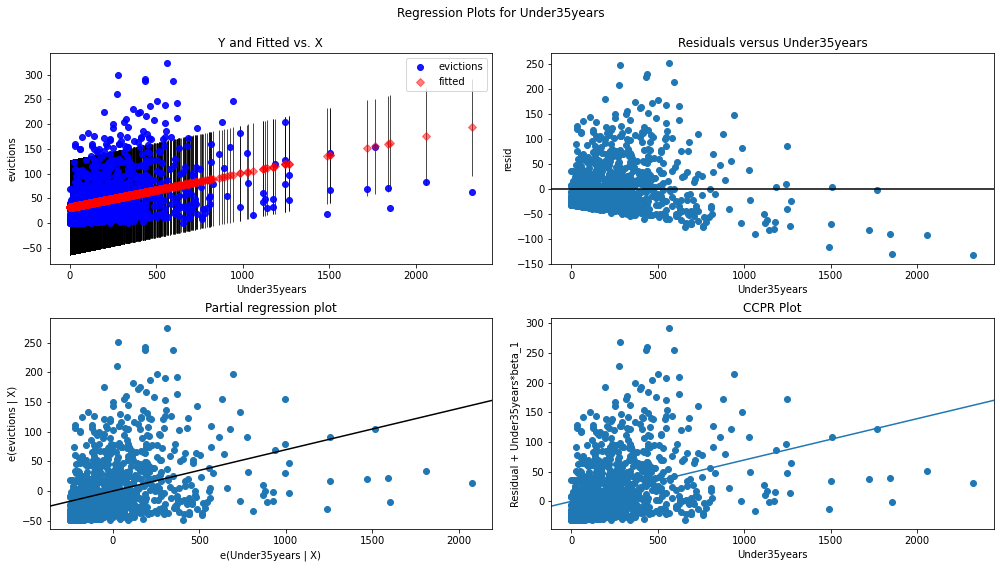

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

#Replace space w/underscores
data_ct2.columns = data_ct2.columns.str.replace(' ', '')

# fit simple linear regression model
lm = ols('evictions ~ Under35years',
                   data=data_ct2).fit()
  
# print summary
print(lm.summary())
# adjust figure size
fig = plt.figure(figsize=(14, 8))
# show regression plots
fig = sm.graphics.plot_regress_exog(lm,
                                    'Under35years',
                                    fig=fig)

In [ ]:
#export data
data_ct2.to_csv("renters_data_ct.csv")